The goal of this work is to study the damage level of buildings after the 2009 earthquake that devastated the italian city "L'Aquila" and its surroundings. The dataset contains info about around 50'000 buildings. The goal is to predict the damage level of each building, which is a categorical variable with 4 levels, using a range of information regarding the buildings such as the number of floors, age of the building, latitude and longitude of the building etc. 
More details about the dataset can be found in the data_preprocessing notebook where we created a one-hot signature for each building. It is worth noting that the model will not be given the coordinates of the epicenters of the earthquakes, but we will show that the model can identify the highest risk area despite this and automatically center it on the epicenters of the earthquakes.

Let's now work on the model to try and predict the damage level of each building. Let's start by importing the necessary libraries and the dataset containing the one-hot signatures created in the previous notebook.

In [20]:
import torch
import pandas as pd
import numpy as np
import pickle

from IPython.display import clear_output

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
# dataframe = pd.read_csv('signature_dataframe.csv')
dataframe = pd.read_pickle('signature_condensed_dataframe.pkl')
dataframe.head()



,x,y
0,"[-0.8674214516922528, 0.5968959280707078, 1, 0...","[1, 0, 0, 0]"
1,"[-0.664418864464821, 0.4405339408980041, 1, 0,...","[1, 0, 0, 0]"
2,"[-0.21363849853229364, 0.19104651928789274, 0,...","[1, 0, 0, 0]"
3,"[-0.21115149773491346, 0.1691897795630536, 0, ...","[1, 0, 0, 0]"
4,"[-1.4160536746440862, 1.0894816994400685, 1, 0...","[0, 1, 0, 0]"


Let's also report the properties of the unnormlized dataset.

In [22]:
ORIGINAL_PROPERTIES = {'Latitude':{'mean': 42.316818950803125,
                                    'std': 0.13075990982450972,
                                    'max': 42.7362168,
                                    'min': 41.7158661414168
                                    },
                        'Longitude':{'mean': 13.521897196462286,
                                    'std': 0.1894015325303454,
                                    'max': 14.2035408,
                                    'min': 13.0
                                    }
                        }

Let's now define the model as a simple fully connected neural network. We write the class so that the hidden layers size and depth of the model can be easily modified.

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedNN(nn.Module):
    def __init__(self, input_len, output_len, hidden_dim, depth):
        super(FullyConnectedNN, self).__init__()
        self.input_len = input_len
        self.output_len = output_len
        self.depth = depth
        self.hidden_dim = hidden_dim
        self.fc_layers = nn.Sequential()
        
        
        for i in range(depth):
            in_features = self.input_len if i == 0 else self.hidden_dim
            self.fc_layers.add_module(f"fc{i}", nn.Linear(in_features, self.hidden_dim))
            self.fc_layers.add_module(f"relu{i}", nn.ReLU())
        
        self.classifier = nn.Sequential(nn.Linear(self.hidden_dim, self.output_len), nn.Softmax(dim=1))
        self.to(DEVICE)
        # print number of parameters
        print(f"Number of parameters: {sum(p.numel() for p in self.parameters() if p.requires_grad)}")
        
    def forward(self, x):
        x = self.fc_layers(x.view(-1, self.input_len))
        x = self.classifier(x)
        return x


Next we define a CustomDataset class that will be used to load the data in batches. This takes the pandas dataframe as input and returns the one-hot signatures and damage levels as tensors.
This class is necessary in order to use the PyTorch DataLoader class.

In [24]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Get the label for the current sample
        label = torch.Tensor(self.dataframe['y'].iloc[idx]).to(DEVICE)
        
        # Get the input for the current sample
        input = torch.Tensor(self.dataframe['x'].iloc[idx]).to(DEVICE)
        
        return input, label
    
    def train_test_split(self, train_size=0.8):
        train_size = int(train_size * len(self))
        test_size = len(self) - train_size
        return torch.utils.data.random_split(self, [train_size, test_size])





We now split the data into training and testing sets. We use 80% of the data for training and 20% for testing.
We also define the data loaders for the training and testing sets.

In [25]:
dataset = CustomDataset(dataframe)
train_dataset, test_dataset = dataset.train_test_split()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=True)

Now let's calculate a list of weights to be used in the loss function to account for the class imbalance so that the model does not overfit to the majority class.
This is done calculating the support of each class in the whole dataset and dividing the loss score of each class by the support of that class.

In [26]:
# Get weights for each class for balancing loss function

N_CLASSES = len(dataset[0][1])
# get support of each class in dataframe
scalar_df = dataframe['y'].apply(lambda x: np.argmax(x))
weights = scalar_df.value_counts()

# sort weights by key
weights = weights.sort_index()
weights = weights.to_numpy()
weights = torch.Tensor(weights).to(DEVICE)

ALPHA = torch.ones(N_CLASSES).to(DEVICE)/weights


ALPHA

tensor([2.5090e-05, 3.9078e-04, 4.1254e-04, 2.6688e-04], device='cuda:0')

We can also clamp these weight so that the model does not overfit to the minority classes (not necessary here), and normalize the weights so that they sum to 1.

In [27]:
# clamp alpha to avoid exessive weight on rare classes
ALPHA = ALPHA.clamp(min(ALPHA).item(), max(ALPHA).item()) # multiply by 0.x (if necessary) to avoid overfitting
# normalize alpha
ALPHA = ALPHA/ALPHA.sum()
ALPHA

tensor([0.0229, 0.3568, 0.3767, 0.2437], device='cuda:0')

For the loss function we use a modified version of BCELoss that allows to give weights to the different classes a priori. This is necessary because the dataset is highly imbalanced.

In [28]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=0.05, logits=True, reduction='elementwise_mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
            
        
        
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'elementwise_mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else: 
            return F_loss
        
        
class FocalLossWithClassBalancing(nn.Module):
    def __init__(self, alpha=ALPHA, gamma=2, reduction='elementwise_mean'): # <----------------------------- alpha should be a list/tensor of length N_CLASSES
        super(FocalLossWithClassBalancing, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        if alpha is None:
            self.alpha = torch.ones(N_CLASSES, dtype=torch.float32).to(DEVICE)    
        else:
            self.alpha = torch.tensor(alpha, dtype=torch.float32).to(DEVICE)
            
    def forward(self, inputs, targets, alpha=None):
        if alpha != None:
            self.alpha = torch.tensor(alpha, dtype=torch.float32).to(DEVICE)        
        
        BCE_loss = torch.clamp(targets * inputs, 0.000001, 1)

        F_loss = -(self.alpha.repeat(targets.shape[0], 1) * (1-BCE_loss)**self.gamma * BCE_loss.log())
        if self.reduction == 'elementwise_mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss
        
class BalancedBCELoss(nn.Module):
    def __init__(self, alpha=ALPHA, reduction='elementwise_mean'):
        super(BalancedBCELoss, self).__init__()
        self.reduction = reduction
        if alpha is None:
            self.alpha = torch.ones(N_CLASSES, dtype=torch.float32).to(DEVICE)    
        else:
            self.alpha = torch.tensor(alpha, dtype=torch.float32).to(DEVICE)
            
    def forward(self, inputs, targets, alpha=None):
        if alpha != None:
            self.alpha = torch.tensor(alpha, dtype=torch.float32).to(DEVICE)        
        
        BCE_loss = torch.clamp(targets * inputs, 0.000001, 1)

        F_loss = -(self.alpha.repeat(targets.shape[0], 1) * BCE_loss.log())
        if self.reduction == 'elementwise_mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

And all that is left to do is to define the training loop and the testing loop. We make use of sklearn's metrics to calculate the accuracy, precision, recall and F1 score.

In [29]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report
EPICENTER = [13.466489, 42.366599]

def plot_risk_map(model, test_loader):
    model.eval()
    grid = np.zeros((60,60))
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            for x in range(-30,30,1):
                for y in range(-30,30,1):
                    inputs[:,0] = y/10 # LATITUDE
                    inputs[:,1] = x/10 # LONGITUDE
                    outputs = model(inputs)
                    classes = torch.argmax(outputs, 1)
                    # map classes to colors
                    damages = class_to_color(classes)
                    site_damage = torch.mean(damages)
                    grid[y+30,x+30] = site_damage # <----------------------- be careful with the order of x and y (CHECK THIS)
                    # print(outputs)
            return grid

def plot_risk_map_unnormalized(model, loader, grid_size=0.01):
    model.eval()
    x_min = ORIGINAL_PROPERTIES['Longitude']['min']
    x_max = ORIGINAL_PROPERTIES['Longitude']['max']
    y_min = ORIGINAL_PROPERTIES['Latitude']['min']
    y_max = ORIGINAL_PROPERTIES['Latitude']['max']
    grid_size = grid_size

    # create a 2D grid
    xs = np.arange(x_min, x_max + grid_size, grid_size)
    ys = np.arange(y_min, y_max + grid_size, grid_size)
    xyzs = []
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            for x in xs:
                for y in ys:
                    inputs[:,0] = (y - ORIGINAL_PROPERTIES['Latitude']['mean']) / ORIGINAL_PROPERTIES['Latitude']['std']
                    inputs[:,1] = (x - ORIGINAL_PROPERTIES['Longitude']['mean']) / ORIGINAL_PROPERTIES['Longitude']['std']
                    outputs = model(inputs)
                    classes = torch.argmax(outputs, 1)
                    # map classes to colors
                    damages = class_to_color(classes)
                    site_damage = torch.mean(damages)
                    xyzs.append([x, y, site_damage])
            break
                
    xyzs = np.array(xyzs)
    # 3d plot using xyzs
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.set_title('Risk Map')
    # change perspective
    # ax.view_init(55, 200)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Risk Score')
    # remove z ticks
    ax.set_zticks([])
    ax.scatter3D(xyzs[:,0], xyzs[:,1], xyzs[:,2], c=xyzs[:,2], cmap='viridis', s=5)
    # plot a marker for the epicenter
    # ax.scatter3D(EPICENTER[1], EPICENTER[0], np.arange( 0, 3, 0.05), c='red', marker='.', s=100)
    plt.show()
    
    
    
    # 2d variant
    for data in loader:
        inputs, labels = data
        sites_ys = inputs[:,0] * ORIGINAL_PROPERTIES['Latitude']['std'] + ORIGINAL_PROPERTIES['Latitude']['mean']
        sites_xs = inputs[:,1] * ORIGINAL_PROPERTIES['Longitude']['std'] + ORIGINAL_PROPERTIES['Longitude']['mean']
        labels = torch.argmax(labels, 1).detach().cpu()
        colors = class_to_color(labels)
    
        plt.figure(figsize=(20,20))
        plt.title('Risk Map')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.scatter(xyzs[:,0], xyzs[:,1], c=xyzs[:,2], cmap='viridis', s=200)
        plt.scatter(EPICENTER[0], EPICENTER[1], c='red', marker='x', s=300, label='Epicenter')
        plt.scatter(sites_xs.detach().cpu(), sites_ys.detach().cpu(), c=colors, marker='.', s=25, label='Sites', cmap='PuRd', alpha=0.75)
        #flip y and x axis
        plt.colorbar()
        plt.legend()
        plt.show()
        break
    
    return np.array(xyzs)
    
    
def class_to_color(classes):
    # class 0 has color 0, class 1 has color 2, class 2 has color 3, class 3 has color 1 (COLOR == DAMAGE LEVEL)
    # this mismatch is because of the way the data was generated
    colors = torch.zeros(classes.shape)
    colors[classes == 0] = 0
    colors[classes == 1] = 2
    colors[classes == 2] = 3
    colors[classes == 3] = 1
    return colors

def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, num_epochs, log_interval=10, PLOT_MAP = True):
    model.to(DEVICE)
    train_losses = []
    test_losses = []
    test_scores = []

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0

        model.train()
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            test_loss = 0
            y_true = []
            y_pred = []
            for data in test_dataloader:
                inputs, labels = data
                
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
                
                labels = torch.argmax(labels, dim=1).view(-1, 1)
                predicted = torch.argmax(outputs.data, 1).view(-1, 1)
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(predicted.cpu().numpy().tolist())

        test_loss /= len(test_dataloader)
        test_losses.append(test_loss)
        test_score = classification_report(y_true, y_pred, zero_division=0, output_dict=False)
        
        test_scores.append(classification_report(y_true, y_pred, zero_division=0, output_dict=True))

        if (epoch + 1) % log_interval == 0:
            clear_output(wait=True)
            
            # plot training loss
            fig, ax = plt.subplots()
            ax.plot(train_losses, label='Training Loss')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend()
            
            # plot testing loss
            fig, ax = plt.subplots()
            ax.plot(test_losses, label='Testing Loss')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend()
            
            # plot average f1 score
            fig, ax = plt.subplots()
            ax.plot([score['macro avg']['f1-score'] for score in test_scores], label='Testing F1 Score Macro Avg')
            ax.plot([score['macro avg']['precision'] for score in test_scores], label='Testing Precision Score Macro Avg')
            ax.plot([score['macro avg']['recall'] for score in test_scores], label='Testing Recall Score Macro Avg')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Score')
            ax.legend()
            
            
            # # plot average precision score
            # fig, ax = plt.subplots()
            # ax.plot([score['macro avg']['precision'] for score in test_scores], label='Testing Precision Score Macro Avg')
            # ax.set_xlabel('Epoch')
            # ax.set_ylabel('Precision Score')
            # ax.legend()
            
            # # plot average recall score
            # fig, ax = plt.subplots()
            # ax.plot([score['macro avg']['recall'] for score in test_scores], label='Testing Recall Score Macro Avg')
            # ax.set_xlabel('Epoch')
            # ax.set_ylabel('Recall Score')
            # ax.legend()
            
            # plot f1 score for each class
            fig, ax = plt.subplots()
            for i in range(N_CLASSES):
                ax.plot([score[str(i)]['f1-score'] for score in test_scores], label=f'Class {i}')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('F1 Score')
            ax.legend()
            plt.show()
            
            if PLOT_MAP:
                plot_risk_map_unnormalized(model, test_dataloader)
        
        print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} \nTest Score:\n {test_score} ")



In this cell we either define a new model or load a previously trained one.

In [11]:
model = FullyConnectedNN(input_len=len(dataset[0][0]), output_len=len(dataset[0][1]), hidden_dim=15, depth=8)

# model = pickle.load(open('model.pkl', 'rb'))

Number of parameters: 2809


Lastly, we train the model and save it.

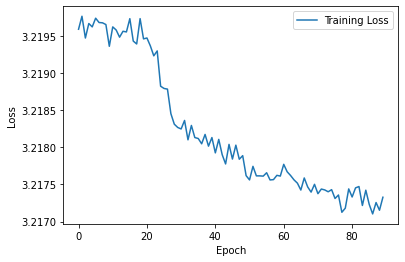

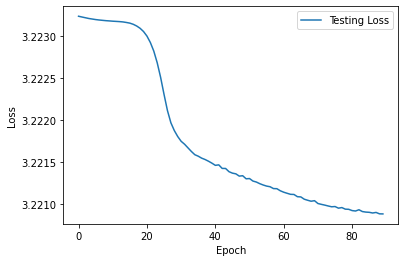

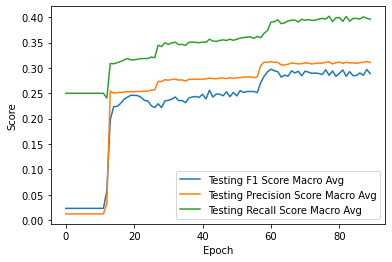

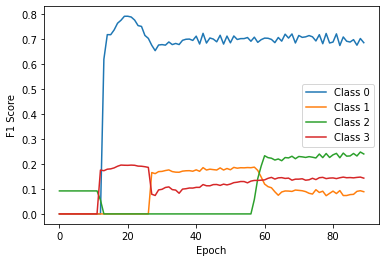

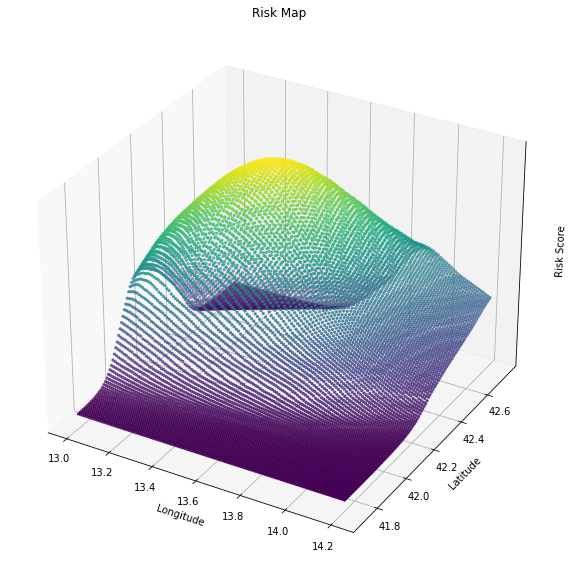

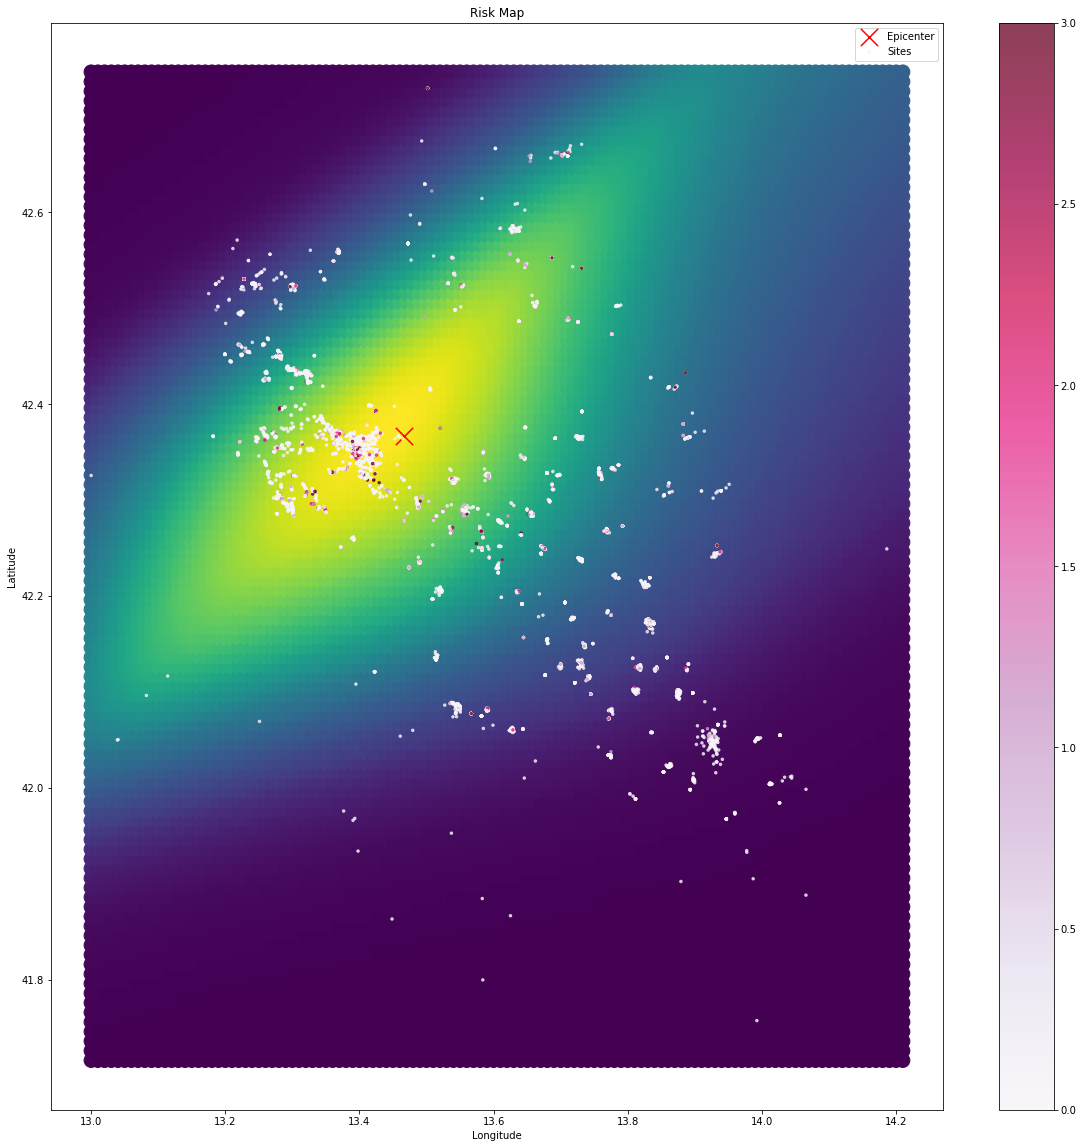

100%|██████████| 90/90 [23:46<00:00, 15.85s/it]

Epoch 90/90: Training Loss: 3.2173 Test Loss: 3.2209 
Test Score:
               precision    recall  f1-score   support

           0       0.93      0.54      0.68      8009
           1       0.07      0.11      0.09       525
           2       0.15      0.64      0.24       468
           3       0.09      0.29      0.14       716

    accuracy                           0.51      9718
   macro avg       0.31      0.40      0.29      9718
weighted avg       0.78      0.51      0.59      9718
 


In [16]:
# Set log_interval to 1 to see the plots after every epoch, this will slow down training significantly
# PLOT_MAP = True to plot the risk map at every log, this will slow down training significantly
train(model, train_loader, test_loader, BalancedBCELoss(), optim.Adam(model.parameters(), lr=0.001), num_epochs=90, log_interval=15, PLOT_MAP = True)

In [17]:
# save model
# pickle.dump(model, open('model_15x8.pkl', 'wb'))

Training can take a while, so we can also load a previously trained model.

In [30]:
# model = pickle.load(open('model_narrow_condensed.pkl', 'rb')) 
model = pickle.load(open('model_25x6.pkl', 'rb'))
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of parameters: 5129


Now we can use a trained model to study the coordinate dependency of the damage level. We do this by creating ficticious buildings with the same one-hot signature as the real ones and varying the coordinates. We then use the trained model to predict the damage level of these ficticious buildings and calculate the average damage level for each coordinate.

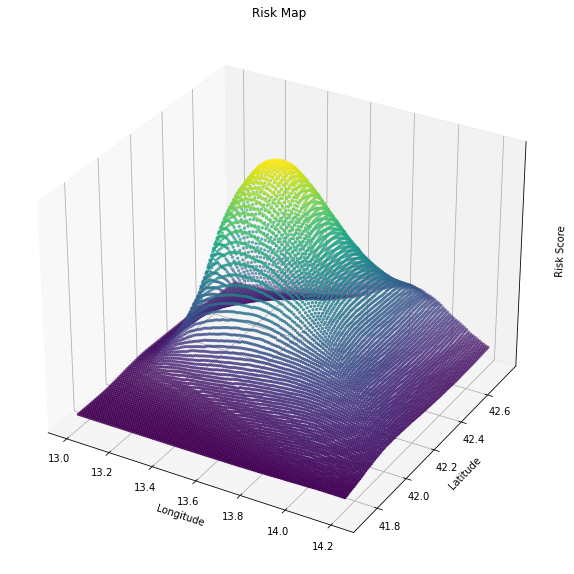

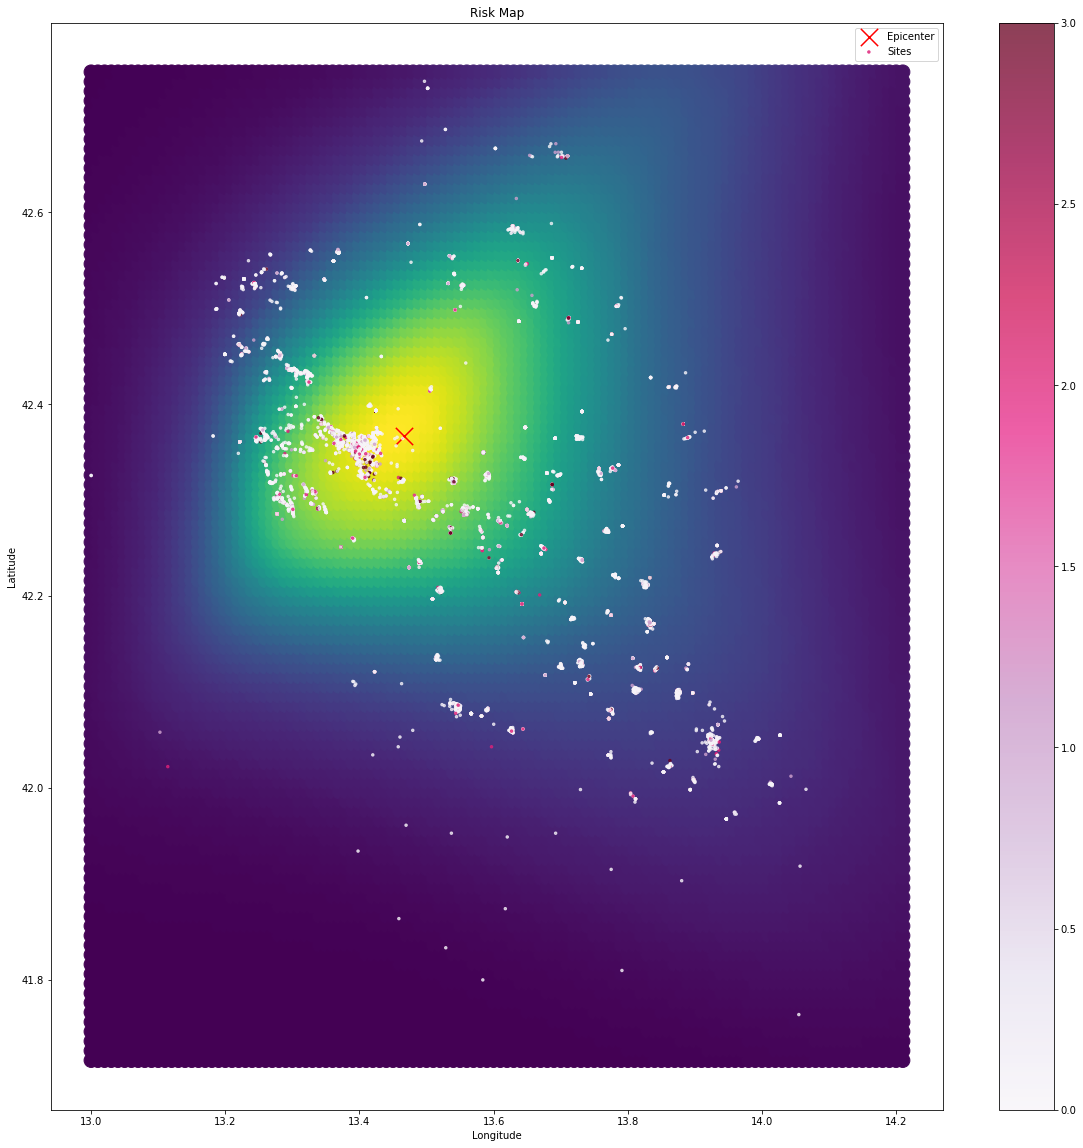

In [23]:
risk_map = plot_risk_map_unnormalized(model, train_loader, grid_size=0.01)

The plot shows the epicenter of the main event in the 2009 earthquake series as a red cross, while the dots represent the recorded sites in the testing dataset. The dots are color-coded based on their actual damage in the dataset, which ranges from 0 to 3, specifically damage to the staircase structure. However, looking at the damages recorded in the testing dataset alone is insufficient for identifying the highest risk zone. This is because the damage of each building is linked not only to its coordinates but also to its individual building characteristics, such as construction quality or number of floors.

To ensure that the model is deriving useful insights from the data, it is crucial to prove that it can separate the spatial dependency of damage from all other building properties. To achieve this, we created dummy buildings with the same characteristics as those in the dataset, but with different coordinates. These buildings were placed on a grid centered around the epicenter, and the vector representation of each dummy building was provided as input to the trained model. The model predicted the damage level for each building if it were located at the chosen point, and the expected damage for each point on the grid was calculated and averaged.

By averaging over many different buildings for each point, the aim is to cancel out the dependence on all other variables, highlighting only the spatial dependence. This also allowed for the interpolation of a 'continuous' risk map, even for points where no buildings were present.

We can clearly see that the model is able to identify the zone around the epicenter as the highest risk zone. This is despite the fact that the model was not given the coordinates of the epicenter as input. Thus we conclude that our approach is able to separate the coordinate dependency from the building signature dependency as the highest risk zone is centered around the actual epicenter and is scarcely biased towards the highest population zone.

Once ensthablished this capability, the same procedure can be applied to all building properties in the same way we did for its coordinates, by choosing a property and averaging over dummy buildings.

In [31]:
unique_values_dict = pickle.load(open('unique_values_dict.pkl', 'rb'))

In [32]:
unique_values_dict

{'identificativoposizioneedificio': array(['Angolo', 'Interno', 'Isolato', 'Estremità'], dtype=object),
 'sez3_struttura_orizzontale_1': array(['Volte senza catene', 'Travi con soletta rigida',
        'Travi con soletta semirigida', 'Travi con soletta deformabile',
        'Volte con catene', 'Non identificata'], dtype=object),
 'sez2_altezzamediapiano': array(['2.50-3.50', 'Non compilato', '3.50-5.0', '<2.50', '>5.0'],
       dtype=object),
 'sez2_pianiinterrati': array([0, 'Non compilato', 1, 2, '>2'], dtype=object),
 'sez3_struttura_verticale_1': array(['Muratura buona qualità', 'Muratura cattiva qualità',
        'Non identificata',
        'Struttura Mista telaio-muratura di buona qualità',
        'Struttura Mista telaio-muratura di cattiva qualità'], dtype=object),
 'sez2_numeropiani': array([2, 3, 1, 5, 4, 6, 'Non compilato', 7, 8, 11, 10, 9], dtype=object),
 'sez2_superficiepiano': array(['50-70', '<50', '130-170', '100-130', 'Non compilato', '70-100',
        '170-230', '400

In [129]:
def study_dummy_columns(model, loader, unique_values_dict, PLOT = True, VERBOSE = False):
    model.eval()
    shapes = [len(v) for v in unique_values_dict.values()]
    
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            categorical_inputs = inputs[:, 2:] # remove lat and long
            
            scores = {key: {} for key in unique_values_dict.keys()}
            
            for i, column in enumerate(unique_values_dict.keys()): # for each column
                
                if i != len(unique_values_dict.keys())-1:
                    if VERBOSE:
                        print('\n Column Name: ',column)
                    offset = sum(shapes[:i])
                    column_onehot = categorical_inputs[:, offset:offset+shapes[i]]
                    dummy_categorical_signatures = categorical_inputs.clone()
                    
                    for j in range(column_onehot.shape[1]): # for each unique value in the column
                        if VERBOSE:
                            print('Value Name:', unique_values_dict[column][j])
                        dummy_onehot = torch.zeros_like(column_onehot)
                        
                        dummy_onehot[:, j] = 1
                        dummy_categorical_signatures[:, offset:offset+shapes[i]] = dummy_onehot
                        
                        dummy_input = torch.cat((inputs[:, :2], dummy_categorical_signatures), dim=1)
                        
                        # calculate dummy output 
                        outputs = model(dummy_input)
                        classes = torch.argmax(outputs, 1)
                        
                        # map classes to colors
                        damages = class_to_color(classes)
                        site_damage = torch.mean(damages)
                        
                        scores[column][unique_values_dict[column][j]] = site_damage.item()
            
            
            if PLOT:                
                for column in scores.keys():
                    fig, ax = plt.subplots()
                    fig.set_figheight(5)
                    fig.set_figwidth(20)
                    # sort scores by key
                    scores[column] = {k: v for k, v in sorted(scores[column].items(), key=lambda item: item[1])}
                    for key in scores[column].keys():
                        ax.bar(str(key), scores[column][key])
                    ax.set_xlabel(column)
                    ax.set_ylabel('Mean Damage')
                    ax.set_title(f'Mean Damage for each value in {column}')
                    plt.show()
                    
                        
                        
                
            return scores
            

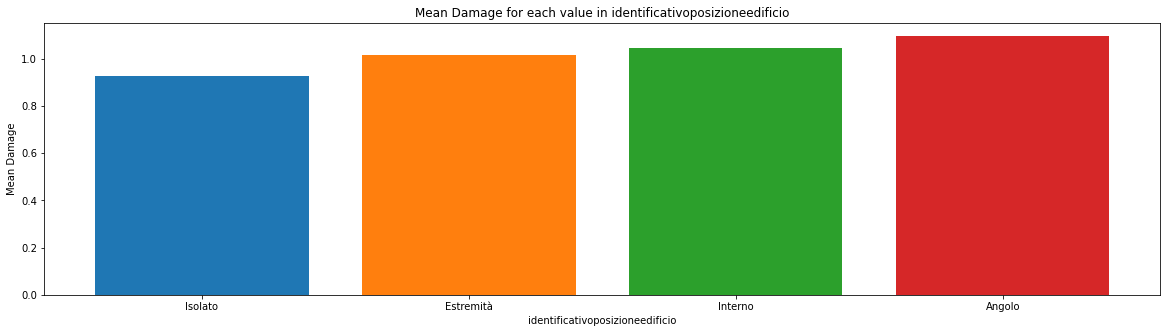

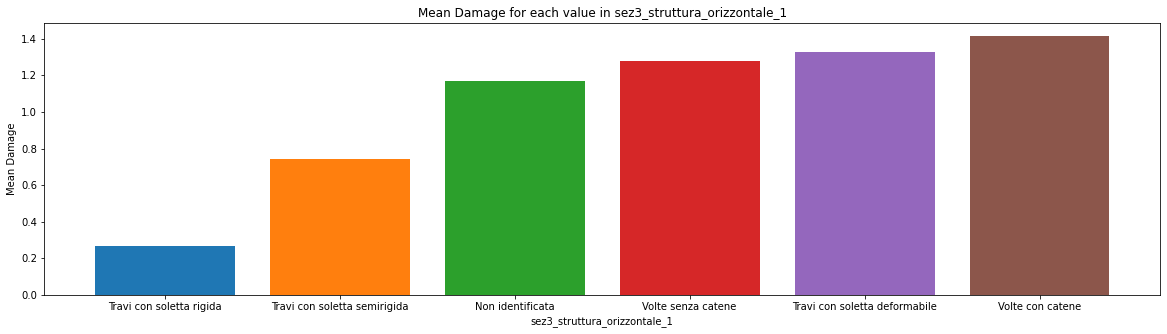

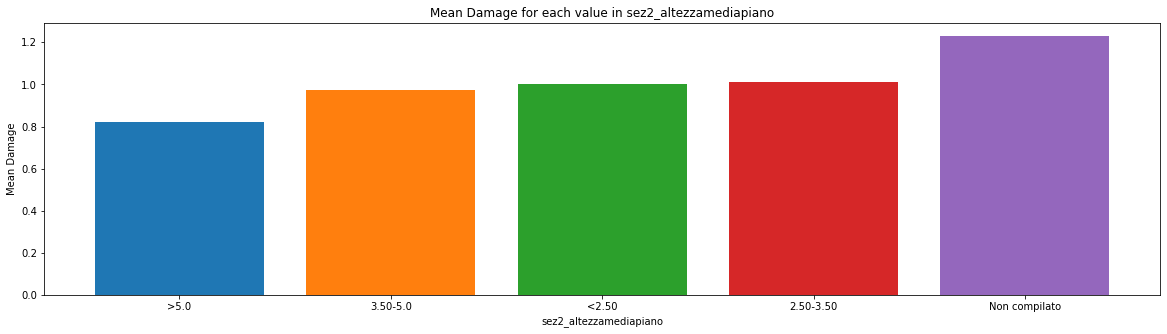

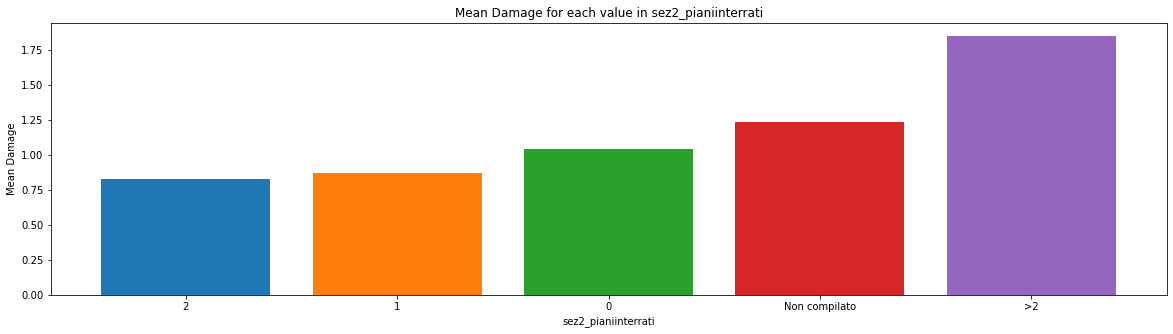

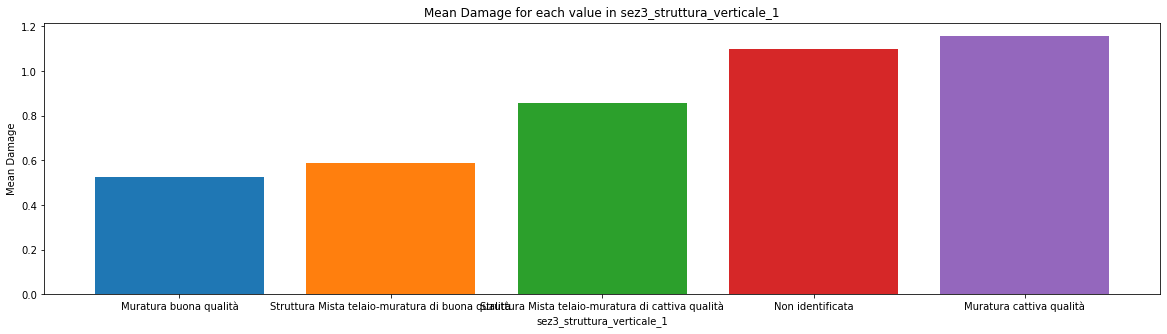

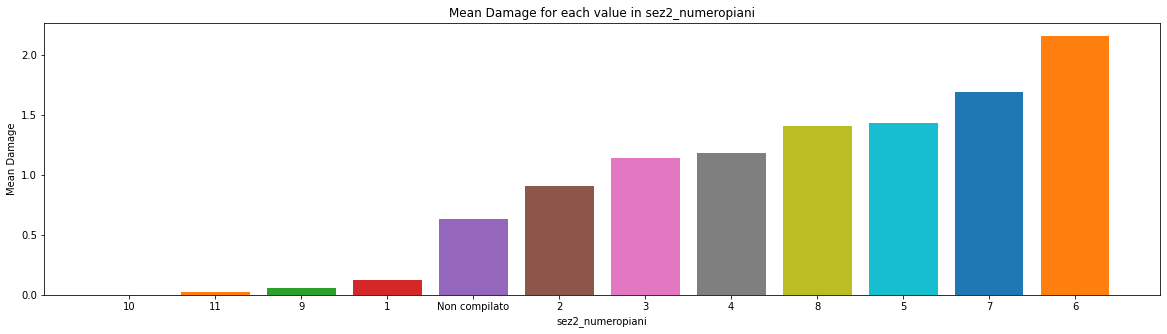

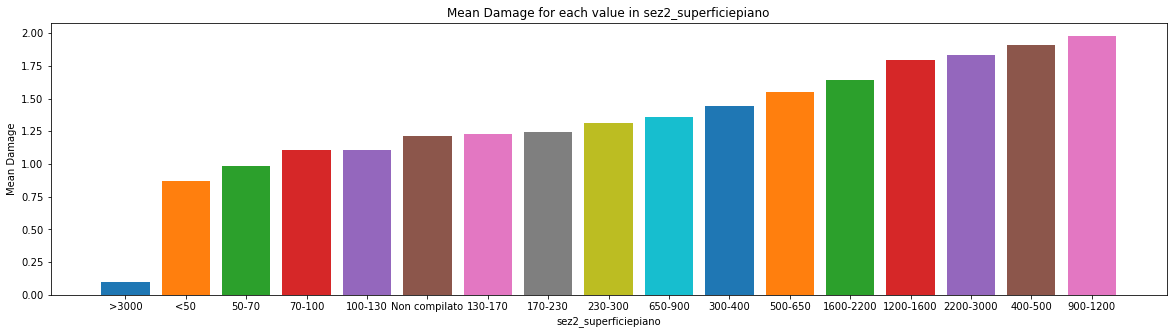

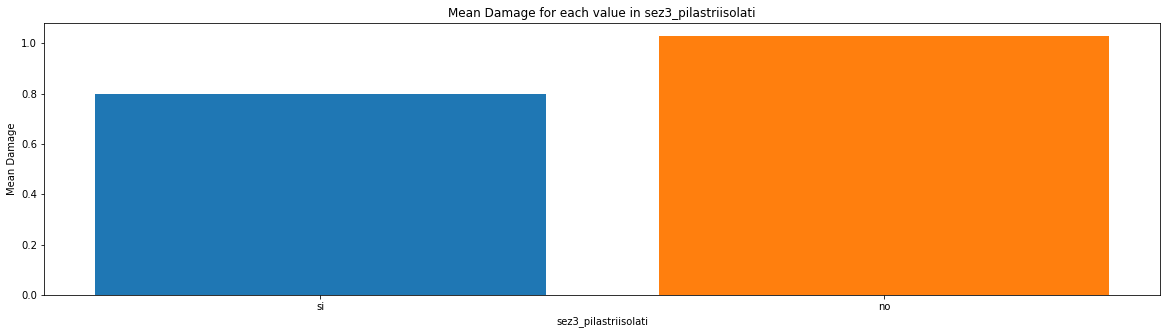

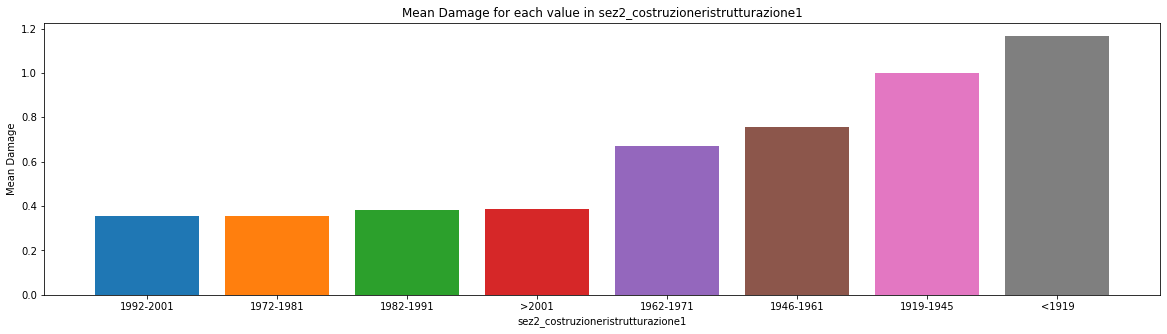

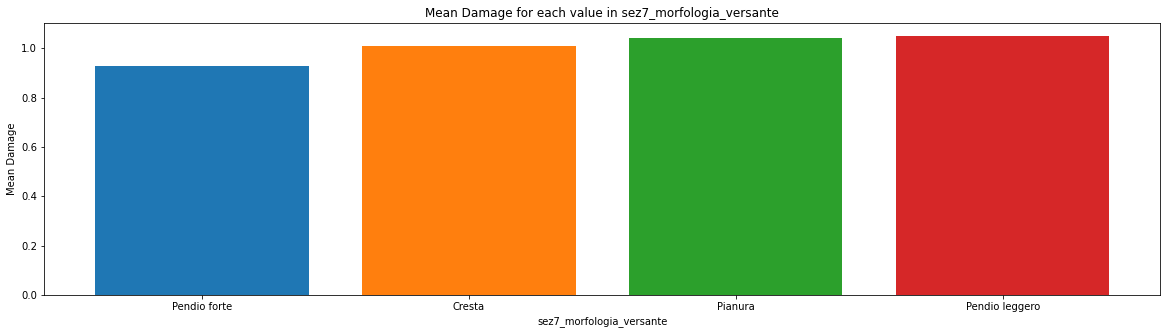

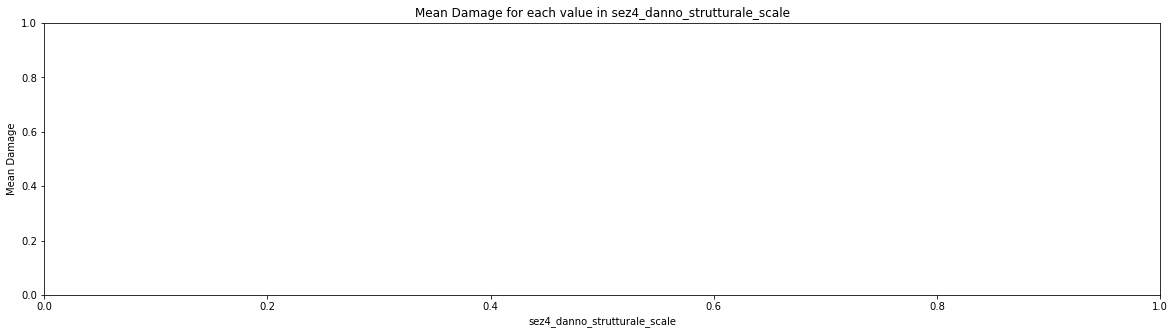

In [130]:
scores = study_dummy_columns(model, test_loader, unique_values_dict)

In [110]:
scores

{'identificativoposizioneedificio': {'Angolo': 1.095801591873169,
  'Interno': 1.0431158542633057,
  'Isolato': 0.9241613745689392,
  'Estremità': 1.0137888193130493},
 'sez3_struttura_orizzontale_1': {'Volte senza catene': 1.279584288597107,
  'Travi con soletta rigida': 0.2654867172241211,
  'Travi con soletta semirigida': 0.7419221997261047,
  'Travi con soletta deformabile': 1.3275365829467773,
  'Volte con catene': 1.4150030612945557,
  'Non identificata': 1.1665980815887451},
 'sez2_altezzamediapiano': {'2.50-3.50': 1.0137888193130493,
  'Non compilato': 1.230088472366333,
  '3.50-5.0': 0.9724223017692566,
  '<2.50': 1.0006173849105835,
  '>5.0': 0.8228030204772949},
 'sez2_pianiinterrati': {0: 1.0413665771484375,
  'Non compilato': 1.2315291166305542,
  1: 0.869726300239563,
  2: 0.8243466019630432,
  '>2': 1.8464704751968384},
 'sez3_struttura_verticale_1': {'Muratura buona qualità': 0.5244906544685364,
  'Muratura cattiva qualità': 1.158571720123291,
  'Non identificata': 1.09